# **NLP project. Fake News detection** 

## **Basic imports** ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import common as cm
import torch

from transformers import DistilBertTokenizer
from transformers import DistilBertModel

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# nltk.download("punkt")
# nltk.download("punkt_tab")
# nltk.download('averaged_perceptron_tagger_eng')
from sklearn.feature_extraction.text import CountVectorizer

## **Loading datasets** ##

In [3]:
true = cm.load_data("True.csv")
true_short = cm.choose_random_part(true, 1000)
X_train_true, X_test_true, y_train_true, y_test_true = cm.divide_data_into_train_and_test(true_short, 0.2)

fake = cm.load_data("Fake.csv")
fake_short = cm.choose_random_part(fake, 1000)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = cm.divide_data_into_train_and_test(fake_short, 0.2)

In [4]:
X_train = cm.merge_datasets(X_train_true, X_train_fake)
X_test = cm.merge_datasets(X_test_true, X_test_fake)
y_train = cm.merge_datasets(y_train_true, y_train_fake)
y_test = cm.merge_datasets(y_test_true, y_test_fake)

In [5]:
X_train, y_train = cm.shuffle_respectively(X_train, y_train)
X_test, y_test = cm.shuffle_respectively(X_test, y_test)

## **Preprocessing datasets** ##

Apart from clean_data() function that we defined in common.py, we have 3 methods of preprocessing the data:

1. Generate contextual word embeddings

2. Generate static word embeddings

3. Use lemmatization, stemmatization and create TF-IDF vector

Each of the above methods will be tested on several models and we can compare which model works the best on which type of preprocessing

### **Helper functions** ###

In [6]:
def load_embeddings(path):
    mapping = dict()

    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            splitted = line.split(" ")
            mapping[splitted[0]] = np.array(splitted[1:], dtype=float)
    return mapping

def avg_document(doc, embeddings):
        avg_emb = np.zeros_like(embeddings['italy'])
        tokens = word_tokenize(doc)
        len = 0
        for token in tokens:
            if token in embeddings.keys():
                avg_emb += embeddings[token]
                len+=1
        if len == 0:
            print('No word in glove embeddings for some article!')
            return avg_emb
        return avg_emb/len

def get_wordnet_pos(tag):
    """
    Map Part-of-Speech (POS) tags to WordNet POS constants.

    Args:
        tag (str): The POS tag (e.g., from nltk.pos_tag) to map to a WordNet POS constant.

    Returns:
        str: The corresponding WordNet POS constant (wordnet.ADJ, wordnet.VERB, wordnet.NOUN, or wordnet.ADV).
        Defaults to wordnet.NOUN if the tag does not match any specific category.
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatize_and_stemmatize(text, stop_words = stopwords.words('english'), lemmatizer = WordNetLemmatizer()):
    text = text.lower()
    # remove digits from text
    text = re.sub(r"\d+", "", text)
    word_pattern = re.compile(r"^[^\W\d_]+$", re.UNICODE)

    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and word_pattern.match(word)]
    pos_tags = pos_tag(filtered_tokens)
    
    lemms = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    return " ".join(lemms)

mapping = load_embeddings('glove.6B.50d.txt') # load embeddings into a dict mapping words into vectors

### **Functions used to preprocess the data** ###

In [7]:
# Generate contextual word embeddings
def create_contextual_embeddings(X: pd.DataFrame) -> np.array:
    """
        Function that creates contextual word embeddings from input data using DistilBERT model
        :param X: ...
        :return: ...
    """
    # Loading DistilBERT model and tokenizer
    model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Tokenizing
    max_len = 512
    X['text'] = X['text'].apply((lambda x: x[:max_len]))
    tokenized = X['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # Padding
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # Masking
    attention_mask = np.where(padded != 0, 1, 0)

    # Running sentences through BERT
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    # Output of DistilBERT will be input for Logistic Regression
    features = last_hidden_states[0][:,0,:].numpy()

    return features

def create_static_embeddings(X, embeddings):
    return [avg_document(doc, embeddings) for doc in X]

def create_TF_IDF(X):
    for _, row in X.iterrows():
        row['text'] = lemmatize_and_stemmatize(row['text'])

    CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
    CountData = CountVec.fit_transform(X['text'])
    count_data_df = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out())
    return count_data_df

In [8]:
X_train_pre, y_train_pre = cm.clean_data(X_train, y_train)
X_test_pre, y_test_pre = cm.clean_data(X_test, y_test)

## **Necessary imports** ##

In [9]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score

In [10]:
def display_metrics(model, y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print()
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = model.classes_), display_labels=model.classes_)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [11]:
# def classify_and_report(classifier):
#     # ------------------- CLASSIFY -----------
#     classifier.fit(train_transformed, y_train_pre['target'])

#     # ------------------- EVALUATE -----------
#     accuracy = classifier.score(test_transformed, y_test_pre)
#     print("Accuracy: {n}%".format(
#         n=100.*accuracy))
#     print(classification_report(y_test_pre, classifier.predict(test_transformed)))

In [12]:
import warnings
warnings.filterwarnings('ignore')

## **Aproach 1 - Contextual Word Embeddings** ##

In [13]:
X_train_contextual = create_contextual_embeddings(X_train_pre)
X_test_contextual = create_contextual_embeddings(X_test_pre)

In [ ]:
# np.save("Embeddings/x_test_contextual_embeddings.npy", X_test_contextual)
# np.save("Embeddings/x_train_contextual_embeddings.npy", X_train_contextual)
# np.save("Embeddings/y_test.npy", y_test_pre)
# np.save("Embeddings/y_train.npy", y_train_pre)

In [24]:
# In case you don't want to generate embeddings from scratch, you can load them from .npy files
# X_train_contextual = np.load("Embeddings/x_train_contextual_embeddings.npy")
# X_test_contextual = np.load("Embeddings/x_test_contextual_embeddings.npy")
# y_train_pre = np.load("Embeddings/y_train.npy")
# y_test_pre = np.load("Embeddings/y_test.npy")

### **Model 1 - SVM** ##

In [26]:
svm = SVC()
svm.fit(X_train_contextual, y_train_pre)

SVC()

Accuracy: 0.945
F1 score: 0.9458128078817734

Recall: 0.96
Precision: 0.9320388349514563


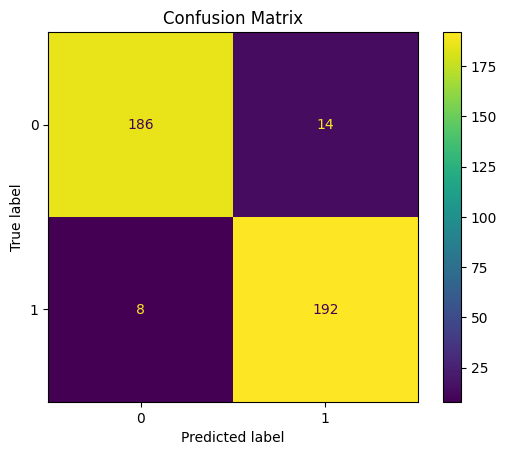

In [27]:
pred_svm_contextual = svm.predict(X_test_contextual)
display_metrics(svm, y_test_pre, pred_svm_contextual)

### **Model 2 - Logistic Regression**

In [28]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_contextual, y_train_pre)

LogisticRegression()

Accuracy: 0.96
F1 score: 0.9605911330049262

Recall: 0.975
Precision: 0.9466019417475728


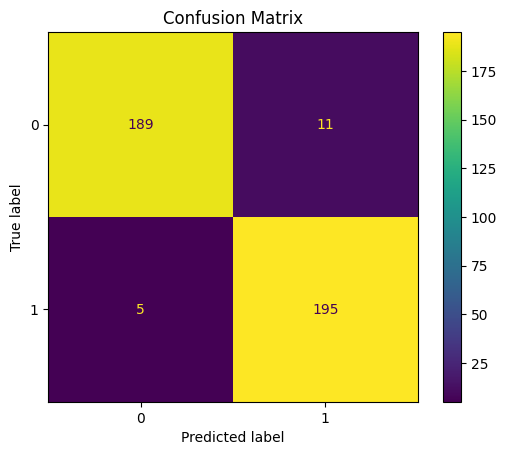

In [29]:
pred_lr_contextual = lr_clf.predict(X_test_contextual)
display_metrics(lr_clf, y_test_pre, pred_lr_contextual)

### **Model 3 - kNN**

In [30]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_contextual, y_train_pre)

KNeighborsClassifier(n_neighbors=7)

Accuracy: 0.93
F1 score: 0.9323671497584541

Recall: 0.965
Precision: 0.9018691588785047


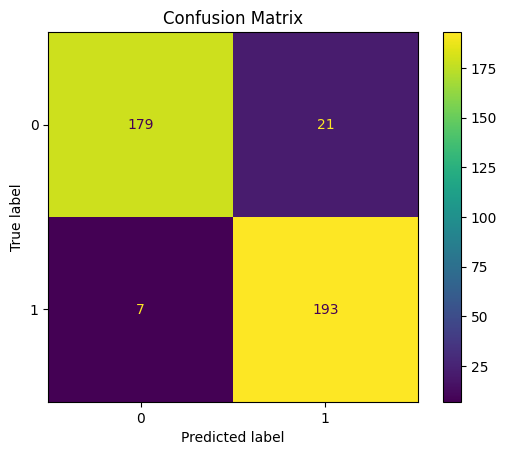

In [31]:
pred_knn_contextual = knn.predict(X_test_contextual)
display_metrics(knn, y_test_pre, pred_knn_contextual)

### **Model 4 - Decision Tree** ##

In [32]:
tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf.fit(X_train_contextual, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.865
F1 score: 0.8676470588235294

Recall: 0.885
Precision: 0.8509615384615384


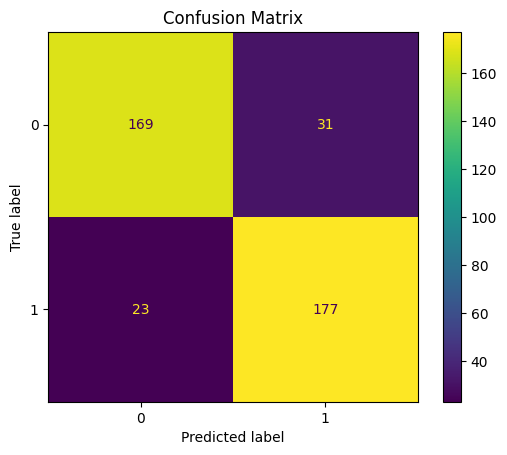

In [33]:
pred_dt_contextual = tree_clf.predict(X_test_contextual)
display_metrics(tree_clf, y_test_pre, pred_dt_contextual)

### **Model 5 - Random Forests** ##

In [34]:
rf = RandomForestClassifier()
rf.fit(X_train_contextual, y_train_pre)

RandomForestClassifier()

Accuracy: 0.9175
F1 score: 0.9181141439205955

Recall: 0.925
Precision: 0.9113300492610837


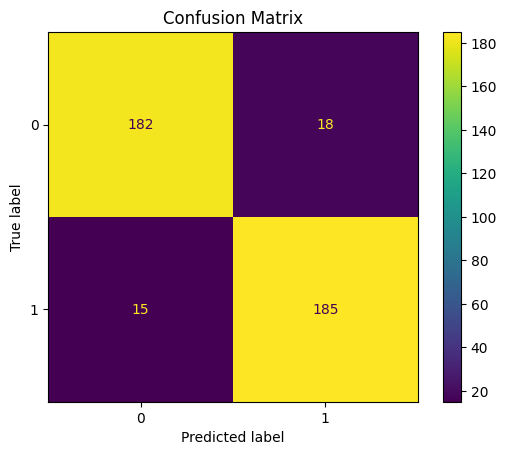

In [35]:
pred_rf_contextual = rf.predict(X_test_contextual)
display_metrics(rf, y_test_pre, pred_rf_contextual)

### **Model 6 - Neural Network**

In [36]:
...

Ellipsis

## **Approach 2 - Static Word Embeddings** ##

In [37]:
X_train_static = create_static_embeddings(X_train_pre['text'], mapping)
X_test_static = create_static_embeddings(X_test_pre['text'], mapping)

No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for so

### **Model 1 - SVM** ##

In [38]:
svm = SVC()
svm.fit(X_train_static, y_train_pre)

SVC()

Accuracy: 0.865
F1 score: 0.8676470588235294

Recall: 0.885
Precision: 0.8509615384615384


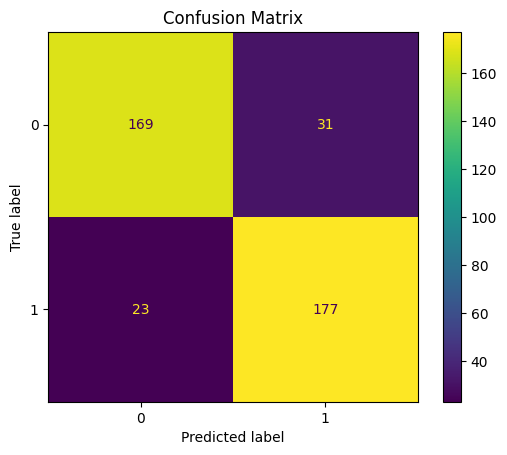

In [39]:
pred_svm_static = svm.predict(X_test_static)
display_metrics(svm, y_test_pre, pred_svm_static)

### **Model 2 - Logistic Regression**

In [40]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_static, y_train_pre)

LogisticRegression()

Accuracy: 0.8725
F1 score: 0.8746928746928747

Recall: 0.89
Precision: 0.8599033816425121


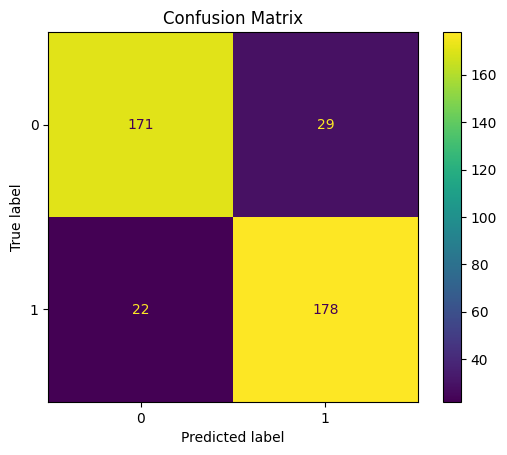

In [41]:
pred_lr_static = lr_clf.predict(X_test_static)
display_metrics(lr_clf, y_test_pre, pred_lr_static)

### **Model 3 - kNN**

In [42]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_static, y_train_pre)

KNeighborsClassifier(n_neighbors=7)

Accuracy: 0.8825
F1 score: 0.8833746898263027

Recall: 0.89
Precision: 0.8768472906403941


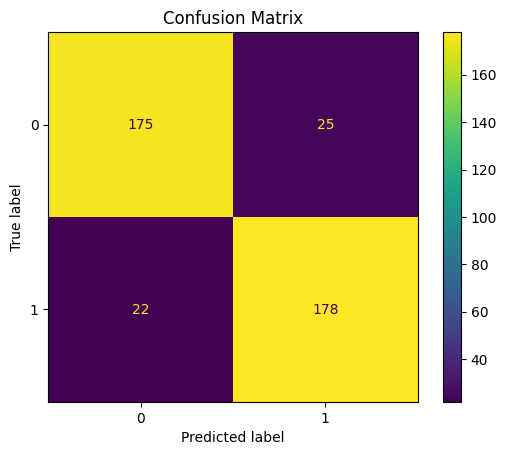

In [43]:
pred_knn_static = knn.predict(X_test_static)
display_metrics(knn, y_test_pre, pred_knn_static)

### **Model 4 - Decision Tree**

In [44]:
tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf.fit(X_train_static, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.8075
F1 score: 0.80306905370844

Recall: 0.785
Precision: 0.8219895287958116


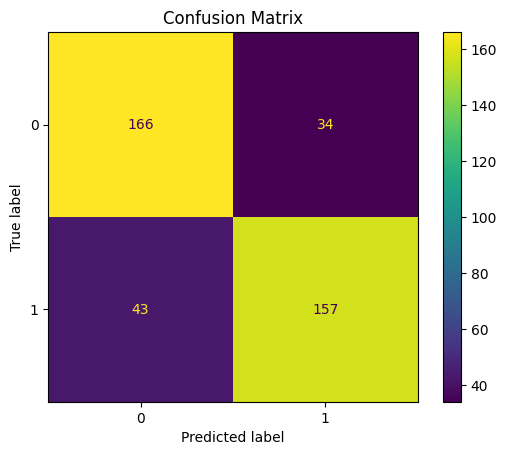

In [45]:
pred_dt_static = tree_clf.predict(X_test_static)
display_metrics(tree_clf, y_test_pre, pred_dt_static)

### **Model 5 - Random Forest**

In [46]:
rf = RandomForestClassifier()
rf.fit(X_train_static, y_train_pre)

RandomForestClassifier()

Accuracy: 0.86
F1 score: 0.8613861386138614

Recall: 0.87
Precision: 0.8529411764705882


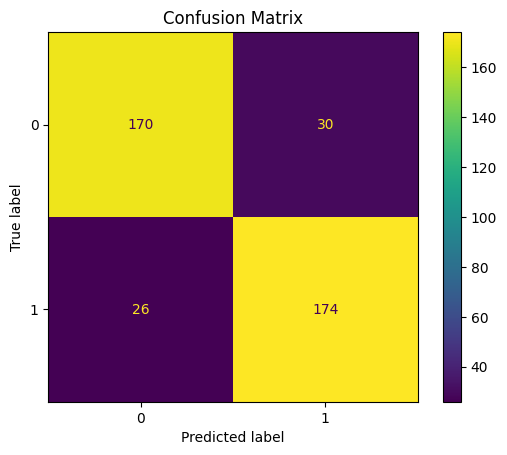

In [47]:
pred_rf_static = rf.predict(X_test_static)
display_metrics(rf, y_test_pre, pred_rf_static)

### **Model 6 - Neural Network**

In [48]:
...

Ellipsis

## **Approach 3 - TF-IDF vector** ##

In [49]:
X_train_tfidf = create_TF_IDF(X_train_pre)
X_test_tfidf = create_TF_IDF(X_test_pre)

X_test_tfidf = X_test_tfidf[X_test_tfidf.columns.intersection(X_train_tfidf.columns)]
X_test_tfidf[X_train_tfidf.columns.difference(X_test_tfidf.columns)] = 0
X_test_tfidf = X_test_tfidf[sorted(X_test_tfidf.columns)]

### **Model 1 - SVM** ###

Accuracy: 0.89
F1 score: 0.8916256157635468

Recall: 0.905
Precision: 0.8786407766990292


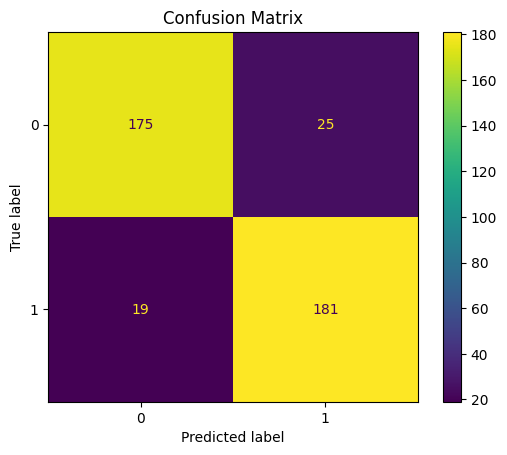

In [50]:
svm = SVC()
svm.fit(X_train_tfidf, y_train_pre)

pred_svm_tfidf = svm.predict(X_test_tfidf)
display_metrics(svm, y_test_pre, pred_svm_tfidf)

### **Model 2 - Logistic Regression** ###

Accuracy: 0.9
F1 score: 0.898989898989899

Recall: 0.89
Precision: 0.9081632653061225


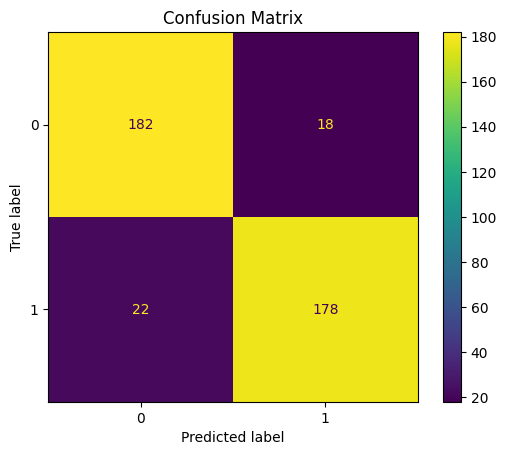

In [51]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train_pre)

pred_lr_tfidf = lr.predict(X_test_tfidf)
display_metrics(lr, y_test_pre, pred_lr_tfidf)

### **Model 3 - kNN** ###

Accuracy: 0.5025
F1 score: 0.009950248756218905

Recall: 0.005
Precision: 1.0


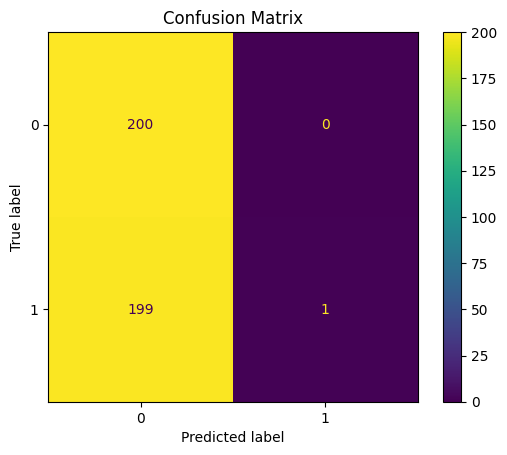

In [52]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_tfidf, y_train_pre)

pred_knn_tfidf = knn.predict(X_test_tfidf)
display_metrics(knn, y_test_pre, pred_knn_tfidf)

### **Model 4 - Decision Tree** ###

Accuracy: 0.79
F1 score: 0.7961165048543689

Recall: 0.82
Precision: 0.7735849056603774


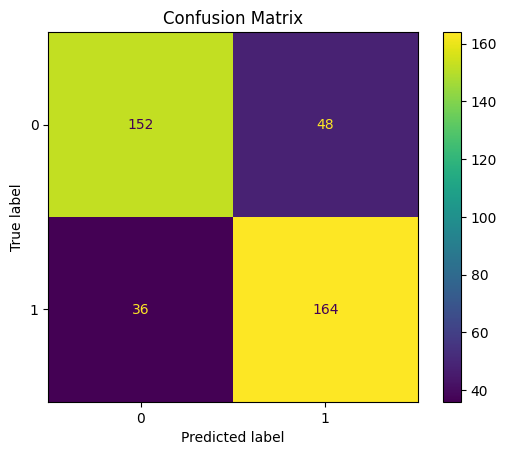

In [53]:
tree_clf = DecisionTreeClassifier(criterion='entropy')
tree_clf.fit(X_train_tfidf, y_train_pre)

pred_dt_tfidf = tree_clf.predict(X_test_tfidf)
display_metrics(tree_clf, y_test_pre, pred_dt_tfidf)

### **Model 5 - Random Forrests** ###

Accuracy: 0.9025
F1 score: 0.9037037037037037

Recall: 0.915
Precision: 0.8926829268292683


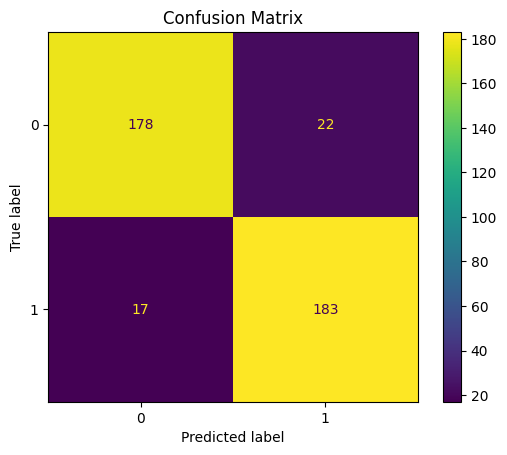

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train_pre)

pred_rf_tfidf = rf.predict(X_test_tfidf)
display_metrics(rf, y_test_pre, pred_rf_tfidf)

## **Summary and comparison of the results** ##

In [57]:
summary = pd.DataFrame(index = ['SVM', 'Linear Regression', 'kNN', 'Decision Tree', 'Random Forest'], columns = ['static', 'contextual', 'tfidf'])
statics = [pred_svm_static, pred_lr_static, pred_knn_static, pred_dt_static, pred_rf_static]
statics_acc = []

contextuals = [pred_svm_contextual, pred_lr_contextual, pred_knn_contextual, pred_dt_contextual, pred_rf_contextual]
contextuals_acc = []

tfidfs = [pred_svm_tfidf, pred_lr_tfidf, pred_knn_tfidf, pred_dt_tfidf, pred_rf_tfidf]
tfidfs_acc = []

for st, ct, tfidf in zip(statics, contextuals, tfidfs):
    statics_acc.append(accuracy_score(y_test_pre, st))
    contextuals_acc.append(accuracy_score(y_test_pre, ct))
    tfidfs_acc.append(accuracy_score(y_test_pre, tfidf))

summary.static = statics_acc
summary.contextual = contextuals_acc
summary.tfidf = tfidfs_acc

print("Accuracies for different preprocessing and different models")
summary

Accuracies for different preprocessing and different models


,static,contextual,tfidf
SVM,0.8650,0.9450,0.8900
Linear Regression,0.8725,0.9600,0.9000
kNN,0.8825,0.9300,0.5025
Decision Tree,0.8075,0.8650,0.7900
Random Forest,0.8600,0.9175,0.9025
